In [1]:
from similarity_searching_sketches.persistence import load_np_array, save_np_array
from similarity_searching_sketches.approx_evaluation import compute_knn_results
from similarity_searching_sketches.approx_evaluation import sort_ids_by_distance
from similarity_searching_sketches.distances import hamming
from similarity_searching_sketches.distances import l1
from similarity_searching_sketches.sketch_producer import MinkowskiSketchProducer
from similarity_searching_sketches.visualization import plot_array
from similarity_searching_sketches.utils import percentage
from similarity_searching_sketches.partitioning import balance_score
from similarity_searching_sketches.correlation_matrix import compute_corr_mtx
from similarity_searching_sketches.correlation_matrix import get_upper_triangle_values
from similarity_searching_sketches.multi_hash_index_stats import stats_to_pandas
from similarity_searching_sketches.utils import df_to_latex
import numpy as np

In [2]:
DATA_FOLDER='/home/matej/data/sketch-testing/dataset_10K/'
PIVOTS_PATH=DATA_FOLDER+'selected_pivots.npy'
MHI_DB_SAVE_PATH=DATA_FOLDER+'mhi_sketch_db.npy'
TRAIN_SUFFIX='train_set.npy'
TEST_SUFFIX='test_set.npy'
DB_PATH_PREFIX='db_'
QUERY_OBJ_PATH_PREFIX='query_obj_'
KNN_RES_PREFIX='knn_res_'
N_QUERY_OBJS=100
K=100
TESTED_SKETCH_LENGTHS=[2,4,8,16,32,64,128]
FILTERING_SPLITS=10
LOG_BY=5000
TRAIN_VS_TEST_LATEX_SAVE_PATH=DATA_FOLDER+'train_vs_test.tex'


#### Generate database and compute k-NN results

In [3]:
def compute_knn(suffix):
    dataset=load_np_array(DATA_FOLDER+suffix)
    np.random.shuffle(dataset)
    queries, dataset=np.split(dataset,[N_QUERY_OBJS])
    ids=np.arange(dataset.shape[0])
    knn_results=compute_knn_results(ids, dataset, queries, K, l1, log_by=LOG_BY)
    save_np_array(DATA_FOLDER+DB_PATH_PREFIX+suffix, dataset)
    save_np_array(DATA_FOLDER+DB_PATH_PREFIX+'ids_'+suffix, ids)
    save_np_array(DATA_FOLDER+QUERY_OBJ_PATH_PREFIX+suffix, queries)
    save_np_array(DATA_FOLDER+KNN_RES_PREFIX+suffix, knn_results)
    return ids,dataset,queries,knn_results
    

In [4]:
ids_train, vecs_train, queries_train, knn_res_train = compute_knn(TRAIN_SUFFIX)
ids_test, vecs_test, queries_test, knn_res_test = compute_knn(TEST_SUFFIX)

INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 13.526966333389282s
 Time from start: 13.526967287063599s


In [5]:
vecs_train.shape

(7900, 4096)

#### Transform database and queries to Sketches

In [6]:
sketch_producer=MinkowskiSketchProducer(pivots_path=PIVOTS_PATH,p=1)

In [7]:
sketches_train=sketch_producer.transform_many(vecs_train)
sketches_queries_train=sketch_producer.transform_many(queries_train)

sketches_test=sketch_producer.transform_many(vecs_test)
sketches_queries_test=sketch_producer.transform_many(queries_test)

In [8]:
sketches_train.shape

(7900, 128)

Save data for MHI experiments

In [9]:
save_np_array(MHI_DB_SAVE_PATH,np.concatenate((sketches_train, sketches_test, sketches_queries_train, sketches_queries_test)))

#### Evaluate approximation quality

In [10]:
def get_sorted_ids(ids, sketches, sketch_queries, sketch_len):
    sketches_shortedned=sketches.T[:sketch_len].T
    sketch_queries_shortened=sketch_queries.T[:sketch_len].T
    return sort_ids_by_distance(ids_train, sketches_shortedned, sketch_queries_shortened, hamming)

sorted_ids_list_train=[]
sorted_ids_list_test=[]

for sketch_len in TESTED_SKETCH_LENGTHS:
    sorted_ids_list_train.append((sketch_len,get_sorted_ids(ids_train, sketches_train,sketches_queries_train, sketch_len)))
    sorted_ids_list_test.append((sketch_len,get_sorted_ids(ids_test, sketches_test,sketches_queries_test, sketch_len)))

INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.7935903072357178s
 Time from start: 0.7935910224914551s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.786231279373169s
 Time from start: 0.7862319946289062s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.7818095684051514s
 Time from start: 0.7818102836608887s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.7923018932342529s
 Time from start: 0.7923033237457275s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.7982401847839355s
 Time from start: 0.798241138458252s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.8102378845214844s
 Time from start: 0.8102385997772217s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.826817512512207s
 Time from start: 0.8268182277679443s


In [11]:
def evaluate_approximation_quality(sorted_ids, true_knn, sketch_len):
    filtering_counts=range(0, sorted_ids.shape[1], int(sorted_ids.shape[1]/FILTERING_SPLITS))
    percentages=[100-int(percentage(cnt, sorted_ids.shape[1])) for cnt in filtering_counts]
    mean_intersection=list()
    for count in filtering_counts:
        intersection_sizes=[]
        for i in range(true_knn.shape[0]):
            intersection_sizes.append(len(set(true_knn[i])&set(sorted_ids[i][:count])))
        mean_intersection.append(np.mean(intersection_sizes))
    plot_array(mean_intersection,xticks=percentages, title='Mean % query result covered in pre-selected (sketch length: '+str(sketch_len)+')', ylabel='Mean % correct in pre-selected', xlabel='% of db filtered ')

#### Approximation quality Train set

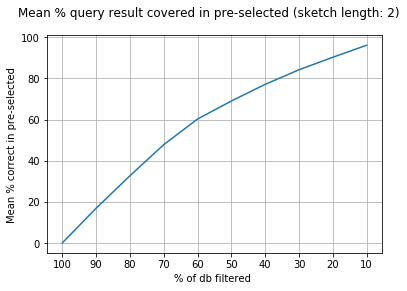

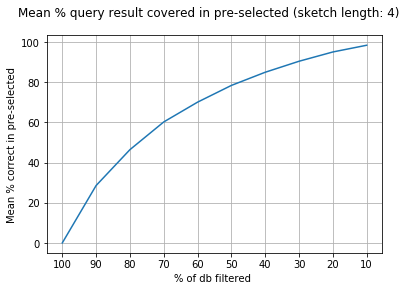

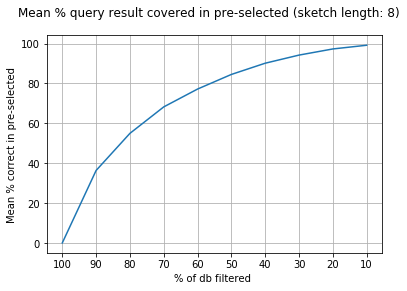

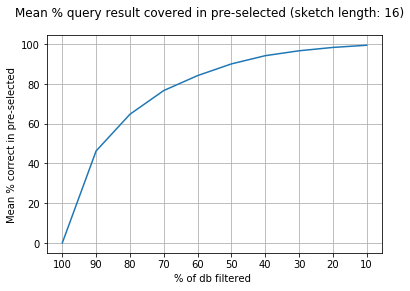

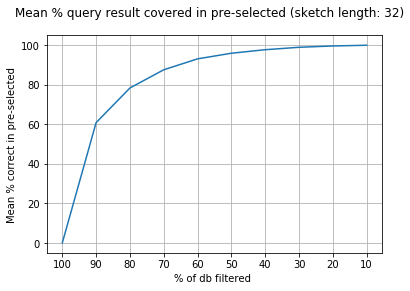

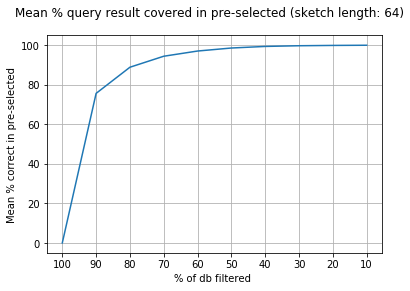

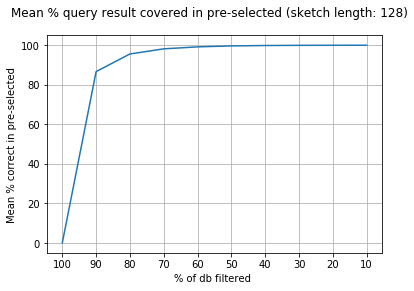

In [12]:
for (sketch_len, sorted_ids) in sorted_ids_list_train:
    evaluate_approximation_quality(sorted_ids, knn_res_train, sketch_len)

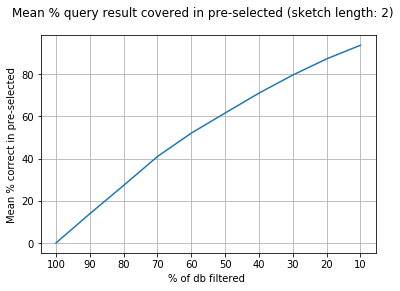

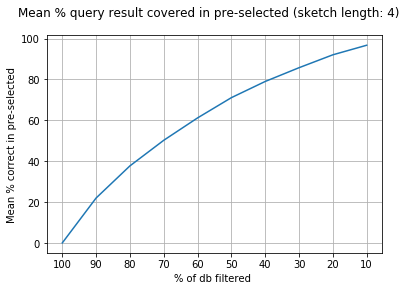

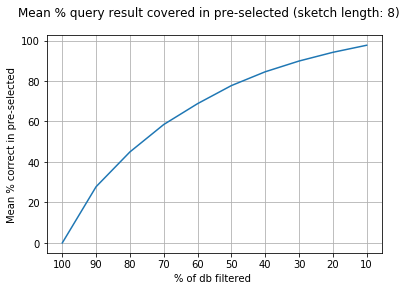

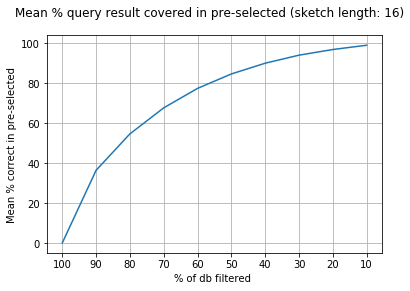

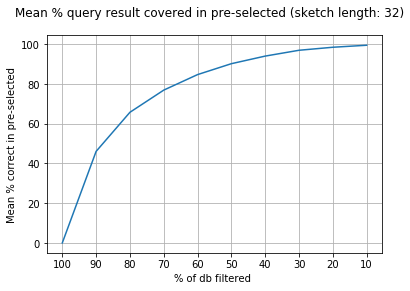

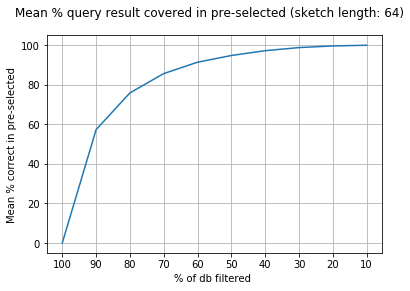

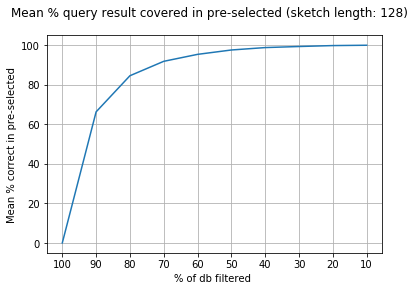

In [13]:
for (sketch_len, sorted_ids) in sorted_ids_list_test:
    evaluate_approximation_quality(sorted_ids, knn_res_test, sketch_len)

#### Evaluate Sketch properties train set vs test set

In [14]:
train_set=np.concatenate((sketches_train, sketches_queries_train))
train_set.shape

(8000, 128)

In [15]:
test_set=np.concatenate((sketches_test, sketches_queries_test))
test_set.shape

(2000, 128)

In [16]:
def mean_balance_score(sketch_set, sketch_size):
    sketches=sketch_set.T[:sketch_size].T
    counts_one=np.zeros(sketches.shape[1])
    for i in range(sketches.shape[0]):
        for j in range(sketches.shape[1]):
            if sketches[i][j]==1:
                counts_one[j]+=1
    return np.mean([balance_score(cnt, sketches.shape[0]) for cnt in counts_one])

def mean_corr(sketch_set,sketch_size):
    sketches=sketch_set.T[:sketch_size].T
    corr_mtx=compute_corr_mtx(sketches)
    return np.mean(get_upper_triangle_values(corr_mtx))
    
    

In [23]:
keys=['p','Balance score train','Corr train','Balance score test','Corr test','Balance score diff', 'Corr diff']
stats={key:[] for key in keys}
for length in TESTED_SKETCH_LENGTHS:
    bal_train=mean_balance_score(train_set,length)
    bal_test=mean_balance_score(test_set,length)
    corr_train=mean_corr(train_set,length)
    corr_test=mean_corr(test_set,length)
    stats['p'].append(length)
    stats['Balance score test'].append(bal_test)
    stats['Balance score train'].append(bal_train)
    stats['Corr test'].append(corr_test)
    stats['Corr train'].append(corr_train)
    stats['Balance score diff'].append(bal_test-bal_train)
    stats['Corr diff'].append(corr_test-corr_train)
stats_df=stats_to_pandas(keys,stats)

/home/matej/project/similarity-searching-sketches/similarity_searching_sketches/multi_hash_index_stats.py:21: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return pd.DataFrame.from_dict({key: stats[key] for key in keys}).reindex_axis(keys, axis=1)


In [24]:
stats_df

,p,Balance score train,Corr train,Balance score test,Corr test,Balance score diff,Corr diff
0,2,0.747125,0.000009,0.751000,0.026923,0.003875,0.026914
1,4,0.746563,0.022915,0.749000,0.043602,0.002438,0.020686
2,8,0.765125,0.049081,0.763375,0.048116,-0.001750,-0.000965
3,16,0.675594,0.073269,0.673625,0.073897,-0.001969,0.000627
4,32,0.676078,0.086071,0.674813,0.087916,-0.001266,0.001845
5,64,0.694023,0.098564,0.693094,0.100005,-0.000930,0.001441
6,128,0.705230,0.119839,0.705156,0.120494,-0.000074,0.000655


In [25]:
df_to_latex(TRAIN_VS_TEST_LATEX_SAVE_PATH,stats_df)